In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

#import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [2]:
# Manual Adjust here
import os
print(os.getcwd())
#os.chdir("Projects/maskrcnn-benchmark2")

/afs/cs.wisc.edu/u/y/u/yuhanl/Downloads/NextGenMaskRCNN-master/code/datasets/generateNew/DefectDetection-MaskRCNN/demo


In [9]:
from os import path
import sys
sys.path.append(path.join(path.dirname(os.getcwd()), ''))
sys.path.append(path.join(path.dirname(os.getcwd())))
from maskrcnn_benchmark.config import cfg
from coco import COCO

In [10]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [9]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

ModuleNotFoundError: No module named 'torch'

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [ ]:
config_file = "../configs/predict.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [ ]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

Let's define a few helper functions for loading images from a URL

In [ ]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

In [107]:
import os
os.listdir('../datasets/train')

['0501_300kx_1nm_clhaadf3_0010.jpg',
 '0501_300kx_1nm_clhaadf3_0014.jpg',
 '0501_300kx_1nm_clhaadf3_0016.jpg',
 '0501_300kx_1nm_clhaadf3_0018.jpg',
 '0501_300kx_1nm_clhaadf3_0022.jpg',
 '0501_300kx_1nm_clhaadf3_0024.jpg',
 '0501_300kx_1nm_clhaadf3_0026.jpg',
 '0501_300kx_1nm_clhaadf3_0028.jpg',
 '0501_300kx_1nm_clhaadf3_0030.jpg',
 '0501_300kx_1nm_clhaadf3_0031.jpg',
 '0501_300kx_1nm_clhaadf3_0034.jpg',
 '0501_300kx_1nm_clhaadf3_0036.jpg',
 '0501_300kx_1nm_clhaadf3_0038.jpg',
 '0501_300kx_1nm_clhaadf3_0040.jpg',
 '0501_300kx_1nm_clhaadf3_0044.jpg',
 '0501_300kx_1nm_clhaadf3_0046.jpg',
 '0501_300kx_1nm_clhaadf3_0048.jpg',
 '0501_300kx_1nm_clhaadf3_0050.jpg',
 '200kV_500kx_p2nm_8cmCL_grain1_0012_n.jpg',
 '200kV_500kx_p2nm_8cmCL_grain1_0109 - Copy.jpg',
 '2501_300kx_1nm_clhaadf3_0036.jpg',
 '2501_300kx_1nm_clhaadf3_0038.jpg',
 '2501_300kx_1nm_clhaadf3_0040.jpg',
 '2501_300kx_1nm_clhaadf3_0044.jpg',
 'dalong3.jpg',
 '2501_300kx_1nm_clhaadf3_0046.jpg',
 '2501_300kx_1nm_clhaadf3_0048.jpg',
 

In [429]:
# from http://cocodataset.org/#explore?id=345434
image_name ='map9_70kx_onzap_CL4100.jpg'
import cv2
im = cv2.imread('../datasets/train/' + image_name)


In [430]:
coco=COCO("../datasets/annotations/train.json")

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


[358.0, 470.0, 49.0, 51.0]
[374.0, 953.0, 20.0, 24.0]
[557.0, 680.0, 87.0, 86.0]
[720.0, 152.0, 52.0, 52.0]
[187.0, 987.0, 14.0, 17.0]


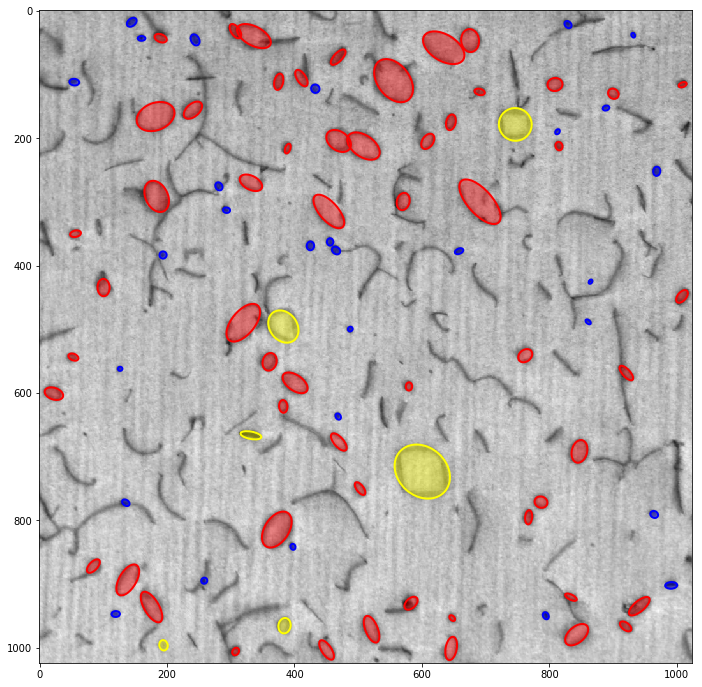

In [431]:
import json
catIds = coco.getCatIds()
imgIds = coco.getImgIds(catIds=catIds );
labels = list()
current_image_list = None
with open('../datasets/annotations/train2.json') as json_data:
    annotation = json.loads(json_data.read())
    current_image_list = annotation['images']
#     print(current_image_list)
    images = annotation['images']
    for i in range(len(images)):
        if(images[i]["file_name"] == image_name):
            imgId = images[i]["id"]
    
    seg = annotation['annotations']
    for i in range(len(seg)):
        if seg[i]['image_id'] == imgId:
            labels.append(seg[i]['category_id'])
            if seg[i]['category_id'] == 3:
                print(seg[i]['bbox'])
    
img = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

plt.imshow(im)
coco.showAnns(anns)

In [432]:
def calc_pos(x):
    if x-128 < 0:
        return 0, 256
    if x + 128 >= 1023:
        return 1023-256, 1023
    return x-128, x+128
def write_json(data, filename='../datasets/annotations/train2.json'): 
    with open(filename,'w') as f: 
        json.dump(data, f) 
rel_pos = []

double_loop = 0
for ann in anns: # each ann is a dict 
    if ann['category_id'] == 3:
        double_loop += 1
#         print(ann['bbox'])
print(double_loop)

image_list = []
for _ in range(double_loop):
    image_list.append(np.zeros((1024, 1024, 3), dtype='uint8'))
idx = 0

# a = cv2.hconcat([im[767:1023, 767:1023, :],
#                                im[767:1023, 767:1023, :]]) 

current_annotations = annotation['annotations']
current_img_num = len(current_image_list)
print("current annotations length", len(current_annotations))
all_image_names = [i['file_name'] for i in annotation['images']]
# print(all_image_names)
for ann in anns:
    
    if ann['category_id'] == 3:
        mid_x = ann['bbox'][0] + ann['bbox'][2]/2
        mid_y = ann['bbox'][1] + ann['bbox'][3]/2
        print(mid_x, mid_y)
        start_x, end_x = calc_pos(mid_x)
        start_y, end_y = calc_pos(mid_y)
        start_x = int(start_x)
        start_y = int(start_y)
        end_x = int(end_x)
        end_y = int(end_y)
        print(start_x,end_x)

        print(start_y,end_y)
#         plt.imshow(im[start_x:end_x, start_y:start_y, :])
        new_img = cv2.hconcat([im[start_y:end_y, start_x:end_x, :],
                               im[start_y:end_y, start_x:end_x, :], 
                               im[start_y:end_y, start_x:end_x, :], 
                               im[start_y:end_y, start_x:end_x, :]])
#         print(new_img)
        new_img2 = cv2.vconcat([new_img, new_img, new_img, new_img])
        image_list[idx] = new_img2
        new_img_name = str(image_name.split('.jpg')[0]) +'_Modified' + str(idx) + '.jpg'
        print(new_img_name)
        new_image_id = len(current_image_list)+1
        if new_img_name not in all_image_names:
            current_image_list.append({'id':new_image_id,"license":1,"coco_url":"","flickr_url":"","width":1024,"height":1024,"file_name":new_img_name,"date_captured":""})
            for i in range(4):
                for j in range(4):
                    new_segmentation = []
                    for seg_index in range(len(ann['segmentation'][0])):
                        if seg_index % 2 ==0:
                            new_segmentation.append((ann['segmentation'][0][seg_index]-start_x) + i * 256)
                        else:
                            new_segmentation.append(ann['segmentation'][0][seg_index]-start_y + j * 256)
                    current_annotations.append({'id': len(current_annotations)+1, 'category_id': 3, 'iscrowd': 0, 'segmentation':[new_segmentation], 
                                                'image_id': new_image_id, 'area': ann['area'], 
                                                'bbox': [ann['bbox'][0]-start_x, ann['bbox'][1]-start_y, ann['bbox'][2], ann['bbox'][3]]})
        idx += 1
        plt.imsave('../datasets/train2/' + new_img_name, new_img2)
        
annotation['images'] = current_image_list
annotation['annotations'] = current_annotations
print("current annotations length", len(current_annotations))

write_json(annotation)

5
current annotations length 8408
382.5 495.5
254 510
367 623
map9_70kx_onzap_CL4100_Modified0.jpg
384.0 965.0
256 512
767 1023
map9_70kx_onzap_CL4100_Modified1.jpg
600.5 723.0
472 728
595 851
map9_70kx_onzap_CL4100_Modified2.jpg
746.0 178.0
618 874
50 306
map9_70kx_onzap_CL4100_Modified3.jpg
194.0 995.5
66 322
767 1023
map9_70kx_onzap_CL4100_Modified4.jpg
current annotations length 8488


In [356]:
plt.imshow(image_list[4])


IndexError: list index out of range

In [57]:
seg = [83.49598656846533, 786.6537195796707, 84.52888863643079, 783.8841547251313, 87.42883435160797, 778.8141852669573, 91.23007937888244, 774.4223639055037, 95.82187862603382, 770.8366415248101, 98.40564643164231, 769.4276364912946, 101.07555352276444, 768.1939897304015, 106.67256742937957, 766.6546356849823, 112.42732824218129, 766.2396891216881, 118.17217733554914, 766.9612390521688, 120.97760001452792, 767.8000876025174, 123.72051676510347, 768.8250124766241, 128.73594402545223, 771.7180065664722, 133.07315978785516, 775.523004870455, 136.60580404233139, 780.1291529487639, 137.98950303752378, 782.7244689789594, 139.19866601552593, 785.4075783972277, 140.6945373615917, 791.0382439203756, 141.07352590291862, 796.8342706899688, 140.32459022527036, 802.6267978421312, 139.47601343153468, 805.4582804203294, 138.44311136356924, 808.2278452748687, 135.54316564839206, 813.2978147330427, 131.74192062111757, 817.6896360944963, 127.15012137396617, 821.2753584751899, 124.5663535683577, 822.6843635087055, 121.89644647723557, 823.9180102695985, 116.29943257062044, 825.4573643150178, 110.54467175781872, 825.872310878312, 104.79982266445087, 825.1507609478313, 101.99439998547209, 824.3119123974827, 99.25148323489654, 823.286987523376, 94.23605597454781, 820.3939934335278, 89.89884021214482, 816.5889951295451, 86.36619595766862, 811.9828470512361, 84.98249696247625, 809.3875310210407, 83.7733339844741, 806.7044216027724, 82.27746263840831, 801.0737560796244, 81.89847409708139, 795.2777293100313, 82.64740977472962, 789.4852021578689, 83.49598656846533, 786.6537195796707]
new_seg = []
for i in range(len(seg)):
    if i % 2 == 0:
        new_seg.append(seg[i])
    else:
        new_seg.append(seg[i] - 640)
    

In [59]:
new_annotations = []


In [60]:
new_bbox = [81.0, 766.0-640, 60.0, 60.0]
new_bboxs = []


In [61]:
for i in range(4):
    single_annotation = []
    for j in range(len(new_seg)):
        if j % 2 == 0:
            single_annotation.append(new_seg[j] + (i * 256))
        if j % 2 == 1:
            single_annotation.append(new_seg[j])
    new_annotations.append(single_annotation)
    new_bboxs.append([new_bbox[0], new_bbox[1], new_bbox[2], new_bbox[3]])
    
    
for i in range(4):
    single_annotation = []
    for j in range(len(new_seg)):
        if j % 2 == 0:
            single_annotation.append(new_seg[j] + (i * 256))
        if j % 2 == 1:
            single_annotation.append(new_seg[j] + 256)
    new_annotations.append(single_annotation)
    new_bboxs.append([new_bbox[0]+(i * 256), new_bbox[1] + 256, new_bbox[2], new_bbox[3]])

for i in range(4):
    single_annotation = []
    for j in range(len(new_seg)):
        if j % 2 == 0:
            single_annotation.append(new_seg[j] + (i * 256))
        if j % 2 == 1:
            single_annotation.append(new_seg[j] + 512)
    new_annotations.append(single_annotation)
    new_bboxs.append([new_bbox[0]+(i * 256), new_bbox[1] + 512, new_bbox[2], new_bbox[3]])
    
    
for i in range(4):
    single_annotation = []
    for j in range(len(new_seg)):
        if j % 2 == 0:
            single_annotation.append(new_seg[j] + (i * 256))
        if j % 2 == 1:
            single_annotation.append(new_seg[j] + 768)
    new_annotations.append(single_annotation)
    new_bboxs.append([new_bbox[0]+(i * 256), new_bbox[1] + 768, new_bbox[2], new_bbox[3]])

In [62]:
len(new_bboxs)

16

In [11]:
new_im = np.zeros((1024, 1024, 3), dtype='uint8')
for i in range(4):
    new_im[0:256, i*256: (i+1)*256, :] = im[640:896, 0:256, :]
for i in range(4):
    new_im[256:512, i*256: (i+1)*256, :] = im[640:896, 0:256, :]
for i in range(4):
    new_im[512:768, i*256: (i+1)*256, :] = im[640:896, 0:256, :]
for i in range(4):
    new_im[768:1024, i*256: (i+1)*256, :] = im[640:896, 0:256, :]

In [12]:
plt.imsave('../datasets/train/2501_300kx_1nm_clhaadf3_0034_Modified.jpg', new_im)

In [13]:
new_annotations[1]

NameError: name 'new_annotations' is not defined

In [14]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

anns = []
for i in range(len(new_bboxs)):
    anns.append({"id": 4328+i, "category_id": 3, "iscrowd": 0, "segmentation": [new_annotations[i]], "image_id": 85, "area": 11059.99016306794, "bbox": new_bboxs[i]})

plt.imshow(new_im)
coco.showAnns(anns)

NameError: name 'new_bboxs' is not defined

In [70]:
anns

[{'id': 4328,
  'category_id': 3,
  'iscrowd': 0,
  'segmentation': [[83.49598656846533,
    146.65371957967068,
    84.52888863643079,
    143.88415472513134,
    87.42883435160797,
    138.81418526695734,
    91.23007937888244,
    134.42236390550374,
    95.82187862603382,
    130.83664152481015,
    98.40564643164231,
    129.4276364912946,
    101.07555352276444,
    128.19398973040154,
    106.67256742937957,
    126.65463568498228,
    112.42732824218129,
    126.23968912168812,
    118.17217733554914,
    126.96123905216882,
    120.97760001452792,
    127.80008760251735,
    123.72051676510347,
    128.82501247662412,
    128.73594402545223,
    131.71800656647224,
    133.07315978785516,
    135.523004870455,
    136.60580404233139,
    140.12915294876393,
    137.98950303752378,
    142.7244689789594,
    139.19866601552593,
    145.40757839722767,
    140.6945373615917,
    151.03824392037563,
    141.07352590291862,
    156.83427068996878,
    140.32459022527036,
    162.6

In [119]:
sub.dtype

dtype('uint8')

In [ ]:
gt_allMask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type1Mask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type2Mask = np.zeros(coco.annToMask(anns[0]).shape)
gt_type3Mask = np.zeros(coco.annToMask(anns[0]).shape)
for i in range(len(anns)):
    if labels[i] == 1:
        gt_type1Mask += coco.annToMask(anns[i])
        gt_type1Mask[gt_type1Mask >= 2] = 1
    if labels[i] == 2:
        gt_type2Mask += coco.annToMask(anns[i])
        gt_type2Mask[gt_type2Mask >= 2] = 1
    if labels[i] == 3:
        gt_type3Mask += coco.annToMask(anns[i])
        gt_type3Mask[gt_type3Mask >= 2] = 1
        
    gt_allMask += coco.annToMask(anns[i])
plt.imshow(gt_allMask)

In [ ]:
plt.imshow(gt_type1Mask)

In [ ]:
plt.imshow(gt_type2Mask)

In [ ]:
plt.imshow(gt_type3Mask)

# Computing the predictions

We provide a run_on_opencv_image function, which takes an image as it was loaded by OpenCV (in BGR format), and #computes the predictions on them, returning an image with the predictions overlayed on the image.


In [ ]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [ ]:
mask, labels = coco_demo.get_predicted_mask_labels(image)
print(mask[0])
new_labels = np.zeros(len(labels))
for i in range(len(labels)):
    new_labels[i] = labels[i].item()
print(new_labels)

In [ ]:
pred_mask = np.zeros((1024,1024,3))
for i in range(len(new_labels)):

    if new_labels[i] == 1:
        pred_mask[:,:,0] += mask[i][0]
    if new_labels[i] == 2:
        pred_mask[:,:,1] += mask[i][0]
    if new_labels[i] == 3:
        pred_mask[:,:,2] += mask[i][0]
plt.imshow(pred_mask[:,:,0])

In [ ]:
type1_pred = [];
type2_pred = [];
type3_pred = [];
allTypes_pred = [];
class_ids = [1,2,3]
mask1 = np.zeros((1024,1024)) # for this image
mask2 = np.zeros((1024,1024))
mask3 = np.zeros((1024,1024))
allmask = np.zeros((1024,1024))
mask = pred_mask
#print(class_ids)

for j in range(len(class_ids)):
    this_channel = mask[:,:,j]
    class_id = class_ids[j]
#     print(np.count_nonzero(this_channel))
    if class_id == 1:
        mask1 = mask1 + this_channel
        
        mask1[mask1 >= 2] = 1
            
    elif class_id == 2:
        mask2 = mask2 + this_channel
        mask2[mask2 >= 2] = 1
        
    else:
        mask3 = mask3 + this_channel
        mask3[mask3 >= 2] = 1
            
    allmask = allmask + this_channel
    allmask[allmask >= 2] = 1
        
#print(np.count_nonzero(mask1)/(1024*1024))        
type1_pred.append(mask1)
type2_pred.append(mask2)
type3_pred.append(mask3)
allTypes_pred.append(allmask)
print(len(type1_pred))

In [ ]:
type1_union = []
type2_union = []
type3_union = []
alltypes_union = []
type1_intersection = []
type2_intersection = []
type3_intersection = []
alltypes_intersection = []
type1_iou = []
type2_iou = []
type3_iou = []
alltypes_iou = []
type1_precision = []
type2_precision = []
type3_precision = []
alltypes_precision = []
type1_recall = []
type2_recall = []
type3_recall = []
alltypes_recall = []

type1_F1 = []
type2_F1 = []
type3_F1 = []
alltypes_F1 = []
i = 0
# for i in range(): 
gt_mask1 = gt_type1Mask  #the first type gt mask of this ith image
gt_mask2 = gt_type2Mask 
gt_mask3 = gt_type3Mask 
gt_allmask = gt_allMask 
    
pred_mask1 = type1_pred[i]
pred_mask2 = type2_pred[i]
pred_mask3 = type3_pred[i]
pred_allmask = allTypes_pred[i]
    
    
type1_union.append(np.count_nonzero(gt_mask1+pred_mask1))
type2_union.append(np.count_nonzero(gt_mask2+pred_mask2))
type3_union.append(np.count_nonzero(gt_mask3+pred_mask3))
alltypes_union.append(np.count_nonzero(gt_allmask+pred_allmask))
    
    

type1_intersection.append(np.count_nonzero((gt_mask1+pred_mask1) == 2))
type2_intersection.append(np.count_nonzero((gt_mask2+pred_mask2) == 2))
type3_intersection.append(np.count_nonzero((gt_mask3+pred_mask3) == 2))
alltypes_intersection.append(np.count_nonzero((gt_allmask+pred_allmask) == 2)) 

type1_iou.append(type1_intersection[i]/type1_union[i])


type2_iou.append(type2_intersection[i]/type2_union[i])


type3_iou.append(type3_intersection[i]/type3_union[i])

alltypes_iou.append(alltypes_intersection[i]/alltypes_union[i])

type1_precision.append(type1_intersection[i]/np.count_nonzero((pred_mask1)))


type2_precision.append(type2_intersection[i]/np.count_nonzero((pred_mask2)))

type3_precision.append(type3_intersection[i]/np.count_nonzero((pred_mask3)))

alltypes_precision.append(alltypes_intersection[i] / np.count_nonzero(pred_allmask))

type1_recall.append(type1_intersection[i]/np.count_nonzero((gt_mask1)))

type2_recall.append(type2_intersection[i]/np.count_nonzero((gt_mask2)))
type3_recall.append(type3_intersection[i]/np.count_nonzero((gt_mask3)))
alltypes_recall.append(alltypes_intersection[i] / np.count_nonzero(gt_allmask))

type1_F1.append(2*(type1_recall[i]* type1_precision[i]) / (type1_recall[i] + type1_precision[i]))
type2_F1.append(2*(type2_recall[i] * type2_precision[i]) / (type2_recall[i] + type2_precision[i]))
type3_F1.append(2*(type3_recall[i] * type3_precision[i]) / (type3_recall[i] + type3_precision[i]))
alltypes_F1.append(2*(alltypes_recall[i] * alltypes_precision[i]) / (alltypes_recall[i] + alltypes_precision[i]))
# # recall
# if np.count_nonzero((gt_mask1)) > 0:
#     type1_recall.append(type1_intersection[i]/np.count_nonzero((gt_mask1)))
# else:
#     type1_recall.append(0)
# if np.count_nonzero((gt_mask2)) > 0:
#     type2_recall.append(type2_intersection[i]/np.count_nonzero((gt_mask2)))
# else:
#     type2_recall.append(0)
# if np.count_nonzero((gt_mask3)) > 0:
#     type3_recall.append(type3_intersection[i]/np.count_nonzero((gt_mask3)))
# else:
#     type3_recall.append(0)
# alltypes_recall.append(alltypes_intersection[i] / np.count_nonzero(gt_allmask))
    
# if type1_recall[i] + type1_precision[i] > 0:
#     type1_F1.append(2*(type1_recall[i]* type1_precision[i]) / (type1_recall[i] + type1_precision[i]))
# else:
#     type1_F1.append(0)
# if type2_recall[i] + type2_precision[i] > 0:
#     type2_F1.append(2*(type2_recall[i] * type2_precision[i]) / (type2_recall[i] + type2_precision[i]))
# else:
#     type2_F1.append(0)
# if type3_recall[i] + type3_precision[i] > 0:
#     type3_F1.append(2*(type3_recall[i] * type3_precision[i]) / (type3_recall[i] + type3_precision[i]))
# else:
#     type3_F1.append(0)
# if (alltypes_recall[i] + alltypes_precision[i]) > 0:
#     alltypes_F1.append(2*(alltypes_recall[i] * alltypes_precision[i]) / (alltypes_recall[i] + alltypes_precision[i]))
# else:
#     alltypes_F1.append(0)

In [ ]:
print('111 loop iou')
print(type1_iou)
print('blackdot iou')
print(type2_iou)
print('100 loop iou')
print(type3_iou)
print('all types iou')
print(alltypes_iou)

In [ ]:
print('111 loop precision')
print(type1_precision)
print('blackdot precision')
print(type2_precision)
print('100 loop precision')
print(type3_precision)
print('all types precision')
print(alltypes_precision)

In [ ]:
print('111 loop recall')
print(type1_recall)
print('blackdot recall')
print(type2_recall)
print('100 loop recall')
print(type3_recall)
print('all types recall')
print(alltypes_recall)

In [ ]:
print('111 loop F1')
print(type1_F1)
print('blackdot F1')
print(type2_F1)
print('100 loop F1')
print(type3_F1)
print('all types F1')
print(alltypes_F1)